## Alignment Comparison 

## Notebook Setup

In [1]:
from collections import defaultdict, namedtuple
import copy
import os
import pickle
import random
import subprocess
import sys
import time
from typing import Dict, List, NamedTuple, Tuple

import joblib
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysam
import scipy.stats as sci_stats
import seaborn as sns
from tqdm.notebook import tqdm

from BSBolt.Utils import AlignmentEvaluator

In [2]:
# set plotting style
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

In [3]:
rc('text', usetex=False)
rc('font', **font)

## Declare Alignment Types

In [4]:
base_dir = '~/BSBoltPaper/'
simulation_dir = f'{base_dir}simulated_reads/'
alignment_dir = f'{base_dir}alignments/'
run_stats_dir = os.getcwd() + '/run_stats/'

In [5]:
simulation_parameters = {
'pe_directional_50': {'directory': f'{simulation_dir}pe_directional_50', 'local':False, 'directional':True, 'read_length':50},
'pe_directional_100': {'directory': f'{simulation_dir}pe_directional_100', 'local':False, 'directional':True, 'read_length':100},
'pe_directional_150': {'directory': f'{simulation_dir}pe_directional_150', 'local':False, 'directional':True, 'read_length':150},
'pe_undirectional_50': {'directory': f'{simulation_dir}pe_undirectional_50', 'local':False, 'directional':False, 'read_length':50},
'pe_undirectional_100': {'directory': f'{simulation_dir}pe_undirectional_100', 'local':False, 'directional':False, 'read_length':100},
'pe_undirectional_150': {'directory': f'{simulation_dir}pe_undirectional_150', 'local':False, 'directional':False, 'read_length':150},
 'se_directional_50': {'directory': f'{simulation_dir}se_directional_50', 'local':False, 'directional':True, 'read_length':50},
'se_directional_100': {'directory': f'{simulation_dir}se_directional_100', 'local':False, 'directional':True, 'read_length':100},
'se_directional_150': {'directory': f'{simulation_dir}se_directional_150', 'local':False, 'directional':True, 'read_length':150},
'se_undirectional_50': {'directory': f'{simulation_dir}se_undirectional_50', 'local':False, 'directional':False, 'read_length':50},
'se_undirectional_100': {'directory': f'{simulation_dir}se_undirectional_100', 'local':False, 'directional':False, 'read_length':100},
'se_undirectional_150': {'directory': f'{simulation_dir}se_undirectional_150', 'local':False, 'directional':False, 'read_length':150},
'pe_low_coverage_directional_50': {'directory': f'{simulation_dir}pe_low_coverage_directional_50', 'local':False, 'directional':True, 'read_length':50},
'pe_low_coverage_directional_100': {'directory': f'{simulation_dir}pe_low_coverage_directional_100', 'local':False, 'directional':True, 'read_length':100},
'pe_low_coverage_directional_150': {'directory': f'{simulation_dir}pe_low_coverage_directional_150', 'local':False, 'directional':True, 'read_length':150},
'se_low_coverage_directional_50': {'directory': f'{simulation_dir}se_low_coverage_directional_50', 'local':False, 'directional':True, 'read_length':50},
'se_low_coverage_directional_100': {'directory': f'{simulation_dir}se_low_coverage_directional_100', 'local':False, 'directional':True, 'read_length':100},
'se_low_coverage_directional_150': {'directory': f'{simulation_dir}se_low_coverage_directional_150', 'local':False, 'directional':True, 'read_length':150},
'pe_error_directional_50': {'directory': f'{simulation_dir}pe_error_directional_50', 'local':False, 'directional':True, 'read_length':50},
'pe_error_directional_100': {'directory': f'{simulation_dir}pe_error_directional_100', 'local':False, 'directional':True, 'read_length':100},
'pe_error_directional_150': {'directory': f'{simulation_dir}pe_error_directional_150', 'local':False, 'directional':True, 'read_length':150}}

In [6]:
alignment_tools = ['biscuit', 'bwa_meth', 'BSBolt', 'bismark', 'bsseeker']

In [7]:
def get_sim_output_paths(alignment_dir, sim_type, tool, run=1):
    output_base = f'{alignment_dir}{sim_type}_x_{run}_x_{tool}'
    if tool == 'BSBolt':
        return f'{output_base}.bam', f'{output_base}.meth_out.CGmap'
    elif tool == 'biscuit':
        return f'{output_base}.bam', f'{output_base}.meth_out_biscuit_out'
    elif tool == 'bwa_meth':
        return f'{output_base}.bam', f'{output_base}.sorted.methylation.txt'
    elif tool == 'bsseeker':
        return output_base, f'{output_base}.meth_out'
    elif tool == 'bismark':
        if 'se' in sim_type:
            return f'{output_base}/sim_1_bismark_bt2.bam', f'{output_base}/sim_1_bismark_bt2.bedGraph.gz'
        else:
            return f'{output_base}/sim_1_bismark_bt2_pe.bam', f'{output_base}/sim_1_bismark_bt2_pe.bedGraph.gz'
    return None, None

## Validate Alignment Runs 

In [8]:
def check_file(file_path):
    if not os.path.exists(file_path):
        return 1
    if os.path.getsize(file_path) < 100:
        return 1
    return 0

In [9]:
def validate_simulation_run(run_name):
    run_checks = [check_file(f'{simulation_dir}{run_name}/sim_1.fq'),
                  check_file(f'{run_stats_dir}{run_name}_alignment_stats.pkl'),
                  check_file(f'{run_stats_dir}{run_name}_meth_call_stats.pkl')]
    if any(run_checks):
        return 1
    tools = []
    for tool in alignment_tools:
        alignment_output, meth_output = get_sim_output_paths(alignment_dir, run_name, tool)
        if check_file(alignment_output) or check_file(meth_output):
            tools.append(tool)
    if tools:
        return tools
    return 0

In [10]:
bad_runs = []

for run in simulation_parameters:
    tool = validate_simulation_run(run)
    if tool:
        bad_runs.append(run)
        print(f'rm -r {run}*')

### Import Alignment Stats

In [11]:
def load_run_stats(stats_dir, run_name):
    with open(f'{stats_dir}{run_name}_alignment_node_stats.pkl', 'rb') as ns:
        node_stats = pickle.load(ns)
    with open(f'{stats_dir}{run_name}_alignment_stats.pkl', 'rb') as aln_sts:
        align_stats = pickle.load(aln_sts)
    with open(f'{stats_dir}{run_name}_meth_call_stats.pkl', 'rb') as mc_sts:
        call_stats = pickle.load(mc_sts)
    return node_stats, align_stats, call_stats

In [12]:
def format_run_stats(call_stats, sim):
    sim_split = sim.split('_')
    formatted_stats = {}
    for run_info, run_stats in call_stats.items():
        formatted_run = run_stats[1]['run_stats']
        for key, value in run_stats[1].items():
            if key != 'run_stats':
                formatted_run[key] = value
        formatted_run['paired'] = True if sim[0:2] == 'pe' else False
        formatted_run['meth_call_time'] = run_stats[0]
        formatted_run['read_length'] = simulation_parameters[sim]['read_length']
        formatted_run['libraryType'] = 'directional' if simulation_parameters[sim]['directional'] else 'undirectional'
        formatted_run['sim_directory'] = simulation_dir + formatted_run['description'].split('_x_')[0] + '/'
        formatted_stats[run_info] = formatted_run
    return formatted_stats

In [13]:
all_run_stats = {}
all_node_stats = {}

In [14]:
for sim in simulation_parameters:
    if sim not in bad_runs:
        node, align, call = load_run_stats(run_stats_dir, sim)
        formatted_stats = format_run_stats(call, sim)
        for key in formatted_stats:
            formatted_stats[key].update(node)
        all_run_stats.update(formatted_stats)

### Evaluate Alignments 

In [15]:
def get_correct_bsseeker_name(read, undirectional=True):
    name = read.qname
    bs_id, conversion = None, None
    strand = 'C' if read.is_reverse else 'W'
    for tag in read.tags:
        if tag[0] == 'XO':
            bs_id = tag[1]
            break
    if bs_id == '+FR' or bs_id == '-FR':
        name = f'{name.split("/")[0]}/1' if read.is_read1 else f'{name.split("/")[0]}/2'
    read_1 = True if '/1' in name else False
    read_1_conversion = bs_id[2]
    if strand == 'W':
        if read_1:
            conversion = 'G2A' if read_1_conversion == 'F' else 'C2T'
        else:
            conversion = 'C2T' if read_1_conversion == 'F' else 'G2A'
    if strand == 'C':
        if read_1:
            conversion = 'G2A' if read_1_conversion == 'F' else 'C2T'
        else:
            conversion = 'C2T' if read_1_conversion == 'F' else 'G2A'

    return name, f'{strand}{conversion}'

In [16]:
def get_bsbolt_strand(read):
    for tag in read.tags:
        if tag[0] == 'YS':
            return tag[1].replace('_', '')
    return 'NA'

In [17]:
def get_bismark_strand(read):
    conversion_pattern, strand = None, None
    for tag in read.tags:
        if tag[0] == 'XR':
            conversion_pattern = 'C2T' if tag[1] == 'CT' else 'G2A'
        if tag[0] == 'XG':
            strand = 'C' if tag[1] == 'GA' else 'W'
        if conversion_pattern and strand:
            return f'{strand}{conversion_pattern}'
    return 'NA' 

In [18]:
def get_bwa_strand(read):
    conversion_pattern, strand = None, None
    for tag in read.tags:
        if tag[0] == 'YC':
            conversion_pattern = 'C2T' if tag[1] == 'CT' else 'G2A'
        if tag[0] == 'YD':
            strand = 'W' if tag[1] == 'f' else 'C'
        if conversion_pattern and strand:
            return f'{strand}{conversion_pattern}'
    return 'NA' 

In [19]:
def get_biscuit_strand(read):
    strand = 'NA'
    for tag in read.tags:
        if tag[0] == 'YD':
            strand = 'W' if tag[1] == 'f' else 'C'
    conversion = 'C2T'
    if strand == 'W':
        if read.is_reverse:
            conversion = 'G2A'
    elif strand == 'C':
        if not read.is_reverse:
            conversion = 'G2A'
    return f'{strand}{conversion}'

In [20]:
strand_conversion = {'bwa_meth': get_bwa_strand, 'BSBolt': get_bsbolt_strand, 
                     'biscuit': get_biscuit_strand, 'bismark': get_bismark_strand,
                     'bsseeker': 'NA'}

In [21]:
from BSBolt.Utils.FastqIterator import OpenFastq


def parse_alignment_comment(read_comment):
    chrom, start, end, cigar, ref_strand = read_comment.replace('+', '').strip().split(':')
    return dict(chrom=chrom, start=int(start),
                end=int(end), cigar=cigar, ref_strand=ref_strand)


def get_read_reference_info(fastq_files: List[str] = None):
    reference_info = {}
    fastq_iterators = (OpenFastq(file) for file in fastq_files)
    for fastq in fastq_iterators:
        for line in fastq:
            read_name = line[0].replace('@', '').strip()
            read_info = line[2].strip()
            reference_info[read_name] = read_info
    return reference_info


class AlignmentEvaluator:
    """Evaluate alignment against simulated bisulfite sequencing data.

    Params:

    * *duplicated_regions (dict)*: regions duplicated in the simulation reference, [None]
    * *matching_target_prop (float)*: proportion of alignment that most overlap with target region
                                     for a valid alignment to be called, [0.95]
    """

    def __init__(self, duplicated_regions: Dict[str, Tuple[int, int]] = None, matching_target_prop: float = 0.95,
                 verbose: bool = False):
        self.duplicated_regions = duplicated_regions
        self.matching_target_prop = matching_target_prop
        self.verbose = verbose

    def evaluate_alignment(self, alignment_file: str, 
                           fastq_files: List[str] = None, 
                           detailed_match: bool = False,
                           tool: str = 'BSBolt') -> Dict[str, int]:
        """

        Params:

        * *alignment_file (str)*: path to alignment file
        * *fastq_files (list)*: list of paths to fastq files

        Returns:

        * *alignment_evaluations (dict)*: target alignment stats
        """
        alignment_evaluations = defaultdict(int)
        off_target_reads = {}
        reads_observed = set()
        reference_info = get_read_reference_info(fastq_files=fastq_files)
        for alignment in tqdm(pysam.Samfile(alignment_file), disable=True if not self.verbose else False):
            # read shouldn't have read pair info but added for safety and tools that don't remove
            read_name = alignment.qname.split('/')[0]
            strand = None
            read_name = alignment.qname.split('/')[0]
            if alignment.is_paired and alignment.is_read2:
                read_name = f'{read_name}/2'
            else:
                read_name = f'{read_name}/1'
            if tool == 'bsseeker':
                read_name, strand = get_correct_bsseeker_name(alignment)
            reads_observed.add(read_name)
            alignment_evaluations['Observed'] += 1
            alignment_info = parse_alignment_comment(reference_info[read_name])
            dup_region = False
            if alignment_info['chrom'] in self.duplicated_regions:
                duplicate_range = self.duplicated_regions[alignment_info['chrom']]
                if duplicate_range[0] <= alignment_info['start'] <= duplicate_range[1]:
                    dup_region = True
            dup = 'Dup' if dup_region else 'NoDup'
            if alignment.is_qcfail:
                alignment_evaluations['QC Fail'] += 1
            elif not alignment.is_unmapped:
                if not strand:
                    strand = strand_conversion[tool](alignment)
                chrom_match, matching_prop = self.assess_alignment(alignment, alignment_info, detailed_match)
                on_target = 'On' if chrom_match and matching_prop >= self.matching_target_prop else 'Off'
                secondary = 'Sec' if any([alignment.is_secondary, alignment.is_supplementary]) else 'Prim'
                pair = 'PropPair' if alignment.is_proper_pair else 'Discord'
                strand_match = 'StrandMatch' if strand == alignment_info['ref_strand'] else 'StrandMismatch'
                if on_target == 'On':
                    on_target = 'On' if strand_match == 'StrandMatch' else 'Off'
                alignment_evaluations[f'{on_target}_{secondary}_{pair}_{dup}_{strand_match}'] += 1
            else:
                off_target_reads[read_name] = f'unaligned_{dup}'
                alignment_evaluations['Unaligned'] += 1
        for read, read_info in reference_info.items():
            if read in reads_observed:
                continue
            else:
                alignment_info = parse_alignment_comment(read_info)
                dup_region = False
                if alignment_info['chrom'] in self.duplicated_regions:
                    duplicate_range = self.duplicated_regions[alignment_info['chrom']]
                    if duplicate_range[0] <= alignment_info['start'] <= duplicate_range[1]:
                        dup_region = True
                dup = 'Dup' if dup_region else 'NoDup'
                alignment_evaluations['Unobserved'] += 1
        alignment_evaluations['ReadObserved'] = len(reads_observed)
        alignment_evaluations['SimulatedReads'] = len(reference_info.keys())
        return alignment_evaluations, off_target_reads

    @staticmethod
    def assess_alignment(alignment: pysam.AlignedSegment, alignment_info: Dict, detailed_match: bool = False):
        """ Compare alignment against reference alignment"""
        chrom_match = alignment.reference_name == alignment_info['chrom']
        # assess reference bases that match between the two reads
        if not chrom_match:
            return chrom_match, 0.0
        elif detailed_match:
            matching_pos = np.array(alignment.get_reference_positions(full_length=False))
            base_range = (matching_pos >= alignment_info['start']) & (matching_pos <= alignment_info['end'])
            matching_prop = sum(base_range) / len(alignment_info['cigar'])
            return chrom_match, matching_prop
        else:
            if alignment.reference_end < alignment_info['start'] or alignment.reference_start > alignment_info['end']:
                return chrom_match, 0.0
            alignment_len = alignment.reference_end - alignment.reference_start
            match = (alignment_len - 
                     abs(alignment.reference_end - alignment_info['end']) + 
                     abs(alignment.reference_start - alignment_info['start']))
            matching_prop = 0.0
            if match:
                matching_prop = match / alignment_len
            return chrom_match, matching_prop


In [22]:
def evaluate_alignment(run_stats):
    evaluator = AlignmentEvaluator(duplicated_regions={'chr1': (1000, 10000), 'chr1Dup': (0, 9000)},
                                   matching_target_prop=.95, verbose=True)
    sim_ref = run_stats['sim_directory']
    fastq_files = [f'{sim_ref}sim_1.fq']
    if run_stats['paired']:
        fastq_files.append(f'{sim_ref}sim_2.fq')
    run_stats_update = copy.deepcopy(run_stats)
    read_stats, off_target_reads = evaluator.evaluate_alignment(alignment_file=run_stats['alignment_file'], fastq_files=fastq_files, tool=run_stats['tool'])
    run_stats_update.update(read_stats)
    return run_stats_update, off_target_reads

In [23]:
if not os.path.exists(f'{base_dir}all_alignment_stats'):
    all_stats = joblib.Parallel(n_jobs=4, verbose=10)(joblib.delayed(evaluate_alignment)(run) for run in all_run_stats.values())
    with open(f'{base_dir}all_alignment_stats', 'wb') as out:
        pickle.dump(all_stats, out)
else:
    with open(f'{base_dir}all_alignment_stats', 'rb') as stats:
        all_stats = pickle.load(stats)

In [24]:
cleaned_run_stats = {}
all_off_target = {}

for stat, off_target_reads in all_stats:
    cleaned_run_stats[f'{stat["description"]}_{stat["tool"]}'] = stat
    all_off_target[f'{stat["description"]}_{stat["tool"]}'] = off_target_reads

### Evaluate Methylation Calling

In [25]:
def open_methylation_file(methylation_file, tool='BSBolt'):
    site_description = {'chrom':0, 'pos':2, 'meth_cyto':6, 'total_cyto':7}
    if tool == 'biscuit':
        site_description = {'chrom':0, 'pos':1, 'beta':3, 'total_cyto':4}
    elif tool == 'bwa_meth':
        site_description = {'chrom':0, 'pos':1, 'meth_cyto':4, 'unmeth_cyto':5}
    elif tool == 'bismark':
        site_description = {'chrom':0, 'pos':1, 'meth_cyto':3, 'unmeth_cyto':4}
    with open(methylation_file, 'r') as meth:
        for site in meth:
            site_split = site.strip().split('\t')
            f_values = {key:None for key in site_description.keys()}
            try:
                for key, value in site_description.items():
                    f_values[key] = site_split[value]
            except IndexError as e:
                print(site_split)
                raise e
            yield f_values

In [26]:
def get_formatted_methylation(methylation_file, tool='BSBolt'):
    # chrom, site, converted, total_bases
    formatted_methylation_calls = []
    for line in open_methylation_file(methylation_file, tool):
        # chrom, pos, meth_cyto, unmeth_cyto
        formatted_line = [line['chrom']]
        if tool == 'biscuit':
            formatted_line.append(int(line['pos']))
            meth_cyto = int(round(float(line['beta']) * float(line['total_cyto'])))
            unmeth_cyto = int(line['total_cyto']) - meth_cyto
            formatted_line.extend([meth_cyto, unmeth_cyto])
        elif tool == 'BSBolt' or tool == 'bsseeker':
            formatted_line.append(int(line['pos']) - 1)
            formatted_line.append(int(line['meth_cyto']))
            formatted_line.append(int(line['total_cyto']) - int(line['meth_cyto']))
        elif tool == 'bwa_meth':
            # skip header lines
            try:
                formatted_line.append(int(line['pos']))
            except ValueError:
                continue
            formatted_line.append(int(line['meth_cyto']))
            formatted_line.append(int(line['unmeth_cyto']))
        elif tool == 'bismark':
            # skip header lines
            formatted_line.append(int(line['pos']) - 1)
            formatted_line.append(int(line['meth_cyto']))
            formatted_line.append(int(line['unmeth_cyto']))
        assert len(formatted_line) == 4
        formatted_methylation_calls.append(formatted_line)
    formatted_methylation_calls.sort(key=lambda x: x[1])
    formatted_methylation_calls.sort(key=lambda x: x[0])
    return formatted_methylation_calls

In [27]:
def open_reference_files(simulation_directory, sim_label, simulation_chrom):
    if not os.path.exists(f'{simulation_directory}{sim_label}.{simulation_chrom}.pkl'):
        return None, None
    with open(f'{simulation_directory}{sim_label}.{simulation_chrom}.pkl', 'rb') as ref:
        meth_ref = pickle.load(ref)
    with open(f'{simulation_directory}{sim_label}.{simulation_chrom}_values.pkl', 'rb') as ref:
        value_ref = pickle.load(ref)
    with open(f'{simulation_directory}{sim_label}.{simulation_chrom}_variants.pkl', 'rb') as ref:
        variant_ref = pickle.load(ref)
    merged_ref = {}
    for key, value in value_ref.items():
        chrom, pos = key.split(':')
        # methylation status not counted if methylable base has homozygous variant at pos
        if '_' in pos:
            site_pos, reference, variant = pos.split('_')
            merged_ref[key] = dict(chrom=chrom, pos=int(site_pos), cg=meth_ref[pos][0], meth_level=meth_ref[pos][1], 
                                   context=meth_ref[pos][2], variant=True, reference_base=reference, variant_base=variant,
                                   meth_c=value[0], unmeth_c=value[1])
        else:
            merged_ref[key] = dict(chrom=chrom, pos=int(pos), cg=meth_ref[pos][0], meth_level=meth_ref[pos][1], 
                                   context=meth_ref[pos][2], variant=False, reference_base=None, variant_base=None,
                                   meth_c=value[0], unmeth_c=value[1])
    return merged_ref, variant_ref

In [28]:
def evaluate_cpg_site(ref, call):
    # chrom pos meth_cyto total_cyto unmeth_cyto
    # chrom pos meth_level, context, variant, meth_c, unmeth_c
    meth_c_diff = ref['meth_c'] - call[2]
    unmeth_c_diff = ref['unmeth_c'] - call[3]
    meth_level_diff = abs((ref['meth_c'] / (ref['meth_c'] + ref['unmeth_c'])) - (call[2] / (call[2] + call[3])))
    coverage_diff = abs((ref['meth_c'] + ref['unmeth_c']) - (call[2] + call[3]))
    return np.array((meth_c_diff, unmeth_c_diff, meth_level_diff, coverage_diff, call[2] + call[3], ref['meth_c'] + ref['unmeth_c']))

In [29]:
def get_meth_site_evals(call_file, tool, simulation_directory, sim_label):
    meth_calls = get_formatted_methylation(call_file, tool)
    current_contig = None
    meth_ref, variant_ref = None, None
    meth_evals = []
    for call in tqdm(meth_calls):
        if not call[0]:
            continue
        if call[0] != current_contig:
            meth_ref, variant_ref = open_reference_files(simulation_directory, sim_label, call[0])
            current_contig = call[0]
            if not meth_ref:
                continue
        # bismark call files have empty lines
        else:
            if not meth_ref:
                continue
        try:
            ref_call = meth_ref[f'{call[0]}:{call[1]}']
        except KeyError:
            if call[1] in variant_ref:
                variant_call = variant_ref[call[1]]
                if variant_call['indel']:
                    continue
                ref_pos = f'{call[0]}:{call[1]}_{variant_call["reference"]}_{variant_call["alt"]}'
                try:
                    ref_call = meth_ref[ref_pos]
                except KeyError:
                    continue             
            else:
                continue
        if not ref_call['cg']:
            continue
        if call[2] + call[3] == 0:
            continue
        print(ref_call, call)
        meth_evals.append(evaluate_cpg_site(ref_call, call))
    return np.array(meth_evals) 

In [30]:
def evaluate_call_file(run_stats):
    run_key = f'{run_stats["description"]}_{run_stats["tool"]}'
    meth_out = run_stats['meth_output']
    if run_stats['tool'] == 'bismark':
        meth_out = meth_out.replace('_meth', '')
    if not os.path.exists(meth_out):
        return run_key, None
    meth_eval = get_meth_site_evals(meth_out, 
                                    run_stats['tool'],
                                    f'{run_stats["sim_reference"]}/', 
                                    'sim')
    call_stats = {}
    cats = ['meth_c_diff', 'unmeth_c_diff', 'meth_level_diff', 'coverage_diff', 'called_coverage', 'simulated_coverage']
    for cat, level in zip(cats, np.mean(meth_eval, axis=0)):
        call_stats[f'{cat}_ave'] = level
    for cat, level in zip(cats, np.std(meth_eval, axis=0)):
        call_stats[f'{cat}_std'] = level
    call_stats['CpG_sites_observed'] = meth_eval.shape[0]
    return run_key, call_stats

In [31]:
def evaluate_call_file2(run_stats):
    run_key = f'{run_stats["description"]}_{run_stats["tool"]}'
    meth_out = run_stats['meth_output']
    if run_stats['tool'] == 'bismark':
        meth_out = meth_out.replace('_meth', '')
    if not os.path.exists(meth_out):
        return run_key, None
    meth_eval = get_meth_site_evals(meth_out, 
                                    run_stats['tool'],
                                    f'{run_stats["sim_reference"]}/', 
                                    'sim')
    return meth_eval
    call_stats = {}
    cats = ['meth_c_diff', 'unmeth_c_diff', 'meth_level_diff', 'coverage_diff', 'called_coverage', 'simulated_coverage']
    for cat, level in zip(cats, np.mean(meth_eval, axis=0)):
        call_stats[f'{cat}_ave'] = level
    for cat, level in zip(cats, np.std(meth_eval, axis=0)):
        call_stats[f'{cat}_std'] = level
    call_stats['CpG_sites_observed'] = meth_eval.shape[0]
    return run_key, call_stats

In [32]:
if not os.path.exists(f'{base_dir}all_call_stats'):
    call_stats = joblib.Parallel(n_jobs=4, verbose=10)(joblib.delayed(evaluate_call_file)(run) for run in cleaned_run_stats.values())
    with open(f'{base_dir}all_call_stats', 'wb') as out:
        pickle.dump(call_stats, out)
else:
    with open(f'{base_dir}all_call_stats', 'rb') as stats:
        call_stats = pickle.load(stats)

In [33]:
for run, stats in call_stats:
    cleaned_run_stats[run].update(stats)

In [34]:
tool_names = {'biscuit': 'BISCUIT', 'bwa_meth': 'BWA-Meth', 'BSBolt':'BSBolt', 'bismark':'Bismark', 'bsseeker':'BSSeeker2'}

In [35]:
for run in cleaned_run_stats:
    cleaned_run_stats[run]['Tool'] = tool_names[cleaned_run_stats[run]['tool']]

## Summaryize Simulation Performance

In [37]:
## assess relative performance 
for run in cleaned_run_stats:
    run_description = run.split('_x_')[0]
    ref_run = cleaned_run_stats[f'{run_description}_x_1_BSBolt']
    cleaned_run_stats[run]['Relative Alignment Time'] = cleaned_run_stats[run]['alignment_time'] / ref_run['alignment_time']
    cleaned_run_stats[run]['Relative Methylation Call Time'] = cleaned_run_stats[run]['meth_call_time'] / ref_run['meth_call_time']

In [38]:
mems = []

for key, value in cleaned_run_stats.items():
    mems.append(int(value['MemTotal'].split(' ')[0]))

In [39]:
np.mean(mems)

49546600.0

In [40]:
sim_alignment_df = pd.DataFrame(cleaned_run_stats).fillna(0).T

In [41]:
alignment_dups = [cat for cat in list(sim_alignment_df) if '_Dup' in cat]

In [42]:
alignment_eval_cats = [cat for cat in list(sim_alignment_df) if 'Off_' in cat or 'On_' in cat] + ['QC-Failed']

In [43]:
alignment_on_cats = [cat for cat in list(sim_alignment_df) if 'On_' in cat]

In [44]:
alignment_off_cats = [cat for cat in list(sim_alignment_df) if 'Off_' in cat] + ['QC Failed']

In [45]:
sim_alignment_df['Simulated Reads (millions)'] = sim_alignment_df['SimulatedReads'] / 1000000
sim_alignment_df['Mapped Reads'] = sim_alignment_df[[cat for cat in list(sim_alignment_df) if 'Prim_' in cat]].sum(axis=1)

sim_alignment_df['On Target Alignments'] = sim_alignment_df[[cat for cat in list(sim_alignment_df) if cat in alignment_on_cats]].sum(axis=1)
sim_alignment_df['Off Target Alignments'] = sim_alignment_df[[cat for cat in list(sim_alignment_df) if cat in alignment_off_cats]].sum(axis=1)
sim_alignment_df['Unaligned Reads'] = sim_alignment_df['Unaligned'] + sim_alignment_df['Unobserved']
sim_alignment_df['Total Alignments'] = sim_alignment_df[[cat for cat in list(sim_alignment_df) if cat in alignment_eval_cats]].sum(axis=1)

sim_alignment_df['On Target Alignments / Total'] = sim_alignment_df['On Target Alignments'] / sim_alignment_df['Total Alignments'] 
sim_alignment_df['Off Target Alignments / Total'] = sim_alignment_df['Off Target Alignments'] / sim_alignment_df['Total Alignments']
sim_alignment_df['Precision'] = sim_alignment_df['On Target Alignments'] / sim_alignment_df['Total Alignments'] 
sim_alignment_df['Recall'] = sim_alignment_df['Off Target Alignments']  / sim_alignment_df['Total Alignments']
sim_alignment_df['F1'] = 2 * ((sim_alignment_df['Precision'] * sim_alignment_df['Recall']) / (sim_alignment_df['Precision'] + sim_alignment_df['Recall']))
sim_alignment_df['Mappability'] = sim_alignment_df['Mapped Reads'] / sim_alignment_df['SimulatedReads']

sim_alignment_df['Methylation Call Time (min)'] = sim_alignment_df['meth_call_time'] / 60
sim_alignment_df['Alignment Time (min)'] = sim_alignment_df['alignment_time'] / 60
sim_alignment_df['Reads Aligned / Minute'] = sim_alignment_df['Simulated Reads (millions)'] / sim_alignment_df['Alignment Time (min)'] 
sim_alignment_df['Minutes / Million Reads'] = sim_alignment_df['Alignment Time (min)'] / sim_alignment_df['Simulated Reads (millions)']

In [46]:
sim_alignment_df = sim_alignment_df[[
 'description',
 'output',
 'alignment_time',
 'reference',
 'run_number',
 'alignment_file',
 'sim_reference',
 'meth_output',
 'paired',
 'meth_call_time',
 'read_length',
 'libraryType',
 'Observed',
 'On_Prim_PropPair_NoDup_StrandMatch',
 'On_Prim_PropPair_Dup_StrandMatch',
 'Off_Prim_PropPair_NoDup_StrandMatch',
 'Unobserved',
 'ReadObserved',
 'SimulatedReads',
 'meth_c_diff_ave',
 'unmeth_c_diff_ave',
 'meth_level_diff_ave',
 'coverage_diff_ave',
 'called_coverage_ave',
 'simulated_coverage_ave',
 'meth_c_diff_std',
 'unmeth_c_diff_std',
 'meth_level_diff_std',
 'coverage_diff_std',
 'called_coverage_std',
 'simulated_coverage_std',
 'CpG_sites_observed',
 'Tool',
 'Off_Prim_PropPair_Dup_StrandMatch',
 'QC Fail',
 'Unaligned',
 'Off_Prim_Discord_NoDup_StrandMismatch',
 'Off_Prim_Discord_NoDup_StrandMatch',
 'Off_Prim_PropPair_NoDup_StrandMismatch',
 'On_Prim_Discord_NoDup_StrandMatch',
 'Off_Sec_PropPair_NoDup_StrandMatch',
 'Off_Sec_Discord_NoDup_StrandMismatch',
 'Off_Sec_PropPair_NoDup_StrandMismatch',
 'Off_Sec_Discord_NoDup_StrandMatch',
 'On_Sec_Discord_NoDup_StrandMatch',
 'On_Prim_Discord_Dup_StrandMatch',
 'Off_Prim_Discord_Dup_StrandMismatch',
 'Off_Prim_Discord_Dup_StrandMatch',
 'Off_Prim_PropPair_Dup_StrandMismatch',
 'Off_Sec_Discord_Dup_StrandMismatch',
 'Off_Sec_Discord_Dup_StrandMatch',
 'On_Sec_PropPair_NoDup_StrandMatch',
 'Simulated Reads (millions)',
 'Mapped Reads',
 'On Target Alignments',
 'Off Target Alignments',
 'Unaligned Reads',
 'Total Alignments',
 'On Target Alignments / Total',
 'Off Target Alignments / Total',
 'Mappability',
 'Methylation Call Time (min)',
 'Alignment Time (min)',
 'Reads Aligned / Minute',
 'Minutes / Million Reads',
 'Relative Alignment Time',
 'Relative Methylation Call Time']]

In [47]:
sim_alignment_df.columns = [
    'description',
 'output',
 'Alignment Time (sec)',
 'reference',
 'run_number',
 'alignment_file',
 'sim_reference',
 'meth_output',
 'Sequencing Type',
 'Meth Call Time (sec)',
 'Read Length',
 'Library Type',
 'Observed',
 'On_Prim_PropPair_NoDup_StrandMatch',
 'On_Prim_PropPair_Dup_StrandMatch',
 'Off_Prim_PropPair_NoDup_StrandMatch',
 'Reads Unobserved',
 'Reads Observed',
 'Simulated Reads',
 'meth_c_diff_ave',
 'unmeth_c_diff_ave',
 'CpG Meth Level MAE',
 'CpG Coverage MAE',
 'called_coverage_ave',
 'simulated_coverage_ave',
 'meth_c_diff_std',
 'unmeth_c_diff_std',
 'CpG Meth Level STD',
 'CpG Coverage STD',                                   
 'called_coverage_std',
 'simulated_coverage_std',
 'CpG Sites Observed',
 'Tool',
 'Off_Prim_PropPair_Dup_StrandMatch',
 'QC Fail',
 'Unaligned',
 'Off_Prim_Discord_NoDup_StrandMismatch',
 'Off_Prim_Discord_NoDup_StrandMatch',
 'Off_Prim_PropPair_NoDup_StrandMismatch',
 'On_Prim_Discord_NoDup_StrandMatch',
 'Off_Sec_PropPair_NoDup_StrandMatch',
 'Off_Sec_Discord_NoDup_StrandMismatch',
 'Off_Sec_PropPair_NoDup_StrandMismatch',
 'Off_Sec_Discord_NoDup_StrandMatch',
 'On_Sec_Discord_NoDup_StrandMatch',
 'On_Prim_Discord_Dup_StrandMatch',
 'Off_Prim_Discord_Dup_StrandMismatch',
 'Off_Prim_Discord_Dup_StrandMatch',
 'Off_Prim_PropPair_Dup_StrandMismatch',
 'Off_Sec_Discord_Dup_StrandMismatch',
 'Off_Sec_Discord_Dup_StrandMatch',
 'On_Sec_PropPair_NoDup_StrandMatch',
 'Simulated Reads (millions)',
 'Mapped Reads',
 'On Target Alignments',
 'Off Target Alignments',
 'Unaligned Reads',
 'Total Alignments',
 'On Target Alignments / Total',
 'Off Target Alignments / Total',
 'Mappability',
 'Methylation Call Time (min)',
 'Alignment Time (min)',
 'Reads Aligned (mil) / Minute',
 'Minutes / Million Reads',
 'Relative Alignment Time',
 'Relative Methylation Call Time']

### Clean DataFrame for Tables and Plots

In [48]:
 clean_cats = [
 'Tool',
 'Alignment Time (min)',
 'reference',
 'Sequencing Type',
 'Methylation Call Time (min)',
 'Read Length',
 'Library Type',
 'Reads Observed',
 'Unaligned Reads',
 'Reads Observed',
 'Simulated Reads',
 'CpG Meth Level MAE',
 'CpG Coverage MAE',
 'CpG Meth Level STD',
 'CpG Coverage STD',
 'CpG Sites Observed',
 'Reads Unobserved',
 'Simulated Reads (millions)',
 'Mapped Reads',
 'Total Alignments',
 'On Target Alignments',
 'Off Target Alignments',
 'Unaligned Reads',
 'On Target Alignments / Total',
 'Off Target Alignments / Total',
 'Mappability',
 'Methylation Call Time (min)',
 'Alignment Time (min)',
 'Reads Aligned (mil) / Minute',
 'Minutes / Million Reads',
 'Relative Alignment Time',
 'Relative Methylation Call Time']

In [49]:
sim_alignment_info = sim_alignment_df[clean_cats].T.to_dict()

In [50]:
simulation_details = {'pe_directional_50': {'Average Read Depth': 20, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_directional_100': {'Average Read Depth': 20, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_directional_150': {'Average Read Depth': 20, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_undirectional_50': {'Average Read Depth': 30, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_undirectional_100': {'Average Read Depth': 30, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_undirectional_150': {'Average Read Depth': 30, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'se_directional_50': {'Average Read Depth': 20, 'Mutation Rate':0.005, 'Sequencing Error': 0.005},
                     'se_directional_100': {'Average Read Depth': 20, 'Mutation Rate':0.005, 'Sequencing Error': 0.005},
                     'se_directional_150': {'Average Read Depth': 20, 'Mutation Rate':0.005, 'Sequencing Error': 0.005},  
                     'se_undirectional_50': {'Average Read Depth': 30, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'se_undirectional_100': {'Average Read Depth': 30, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'se_undirectional_150': {'Average Read Depth': 30, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_vec': {'Average Read Depth': 40, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_low_coverage_directional_50': {'Average Read Depth': 8, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_low_coverage_directional_100': {'Average Read Depth': 8, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_low_coverage_directional_150': {'Average Read Depth': 8, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'se_low_coverage_directional_50': {'Average Read Depth': 8, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'se_low_coverage_directional_100': {'Average Read Depth': 8, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'se_low_coverage_directional_150': {'Average Read Depth': 8, 'Mutation Rate':0.005, 'Sequencing Error': 0.005}, 
                     'pe_error_directional_50': {'Average Read Depth': 8, 'Mutation Rate':0.01, 'Sequencing Error': 0.02}, 
                     'pe_error_directional_100': {'Average Read Depth': 8, 'Mutation Rate':0.01, 'Sequencing Error': 0.02}, 
                     'pe_error_directional_150': {'Average Read Depth': 8, 'Mutation Rate':0.01, 'Sequencing Error': 0.02}}

In [51]:
for sim in simulation_details:
    seq_type = 'Paired End' if sim[0:2] == 'pe' else 'Single End'
    lib_type = 'Undirectional' if 'undirectional' in sim else 'Directional'
    simulation_details[sim].update({'Sequencing Type':seq_type, 'Library Type':lib_type})

In [52]:
sim_details_df = pd.DataFrame({key:value for key, value in simulation_details.items() if 'vec' not in key}).T

In [53]:
sim_details_df.to_csv('Simulation_params.csv', index=False)

In [54]:
cleaned_order = ['Tool', 'Sequencing Type', 'Library Type', 'Read Length', 'Average Read Depth', 
                 'Mutation Rate', 'Sequencing Error', 'Simulated Reads', 'Reads Observed', 
                 'Mapped Reads', 'Mappability',
                 'On Target Alignments / Total', 'Off Target Alignments / Total', 
                 'Alignment Time (min)', 'Relative Alignment Time',
                 'Reads Aligned (mil) / Minute', 'Minutes / Million Reads', 
                 'CpG Meth Level MAE', 'CpG Meth Level STD', 'CpG Coverage MAE', 
                 'CpG Coverage STD', 'Methylation Call Time (min)',
                 'Relative Methylation Call Time']

In [55]:
def clean_sim_stats(stats):
    c_stats = dict(stats)
    c_stats.update(simulation_details[c_stats['reference']])
    c_stats['Effective Read Length'] = c_stats['Read Length'] * 2 if c_stats['Sequencing Type']  else c_stats['Read Length']
    return {cat : c_stats[cat] for cat in cleaned_order}

In [56]:
cleaned_sim_stats = {}

for sample, stats in sim_alignment_info.items():
    if 'vec' not in sample:
        cleaned_sim_stats[sample] = clean_sim_stats(stats)

### Format Output Data

In [57]:
output_cats = ['Tool',
 'Sequencing Type',
 'Library Type',
 'Read Length',
 'Average Read Depth',
 'Mutation Rate',
 'Sequencing Error',
 'Simulated Reads',
 'Reads Observed',
 'Mapped Reads',
 'Mappability',
 'On Target Alignments / Total',
 'Off Target Alignments / Total',
 'Alignment Time (min)',
 'Relative Alignment Time',
 'Reads Aligned (mil) / Minute',
 'Minutes / Million Reads',
 'CpG Meth Level MAE',
 'CpG Meth Level STD',
 'CpG Coverage MAE',
 'CpG Coverage STD',
 'Methylation Call Time (min)',
 'Relative Methylation Call Time']

In [58]:
output_df = pd.DataFrame(cleaned_sim_stats).T
output_df = output_df[output_cats].copy()

In [59]:
float_format_cats = [
 'On Target Alignments / Total',
 'Off Target Alignments / Total',
 'Mappability',
 'Alignment Time (min)',
 'Reads Aligned (mil) / Minute',
 'CpG Meth Level MAE',
 'CpG Meth Level STD',
 'CpG Coverage MAE',
 'CpG Coverage STD',
 'Methylation Call Time (min)']

## Generate Output Plot

In [60]:
sns.set(palette="Paired", style='white')
plt.rcParams['legend.title_fontsize'] = 22
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['legend.fontsize'] = 22
plt.rcParams['legend.frameon'] = False

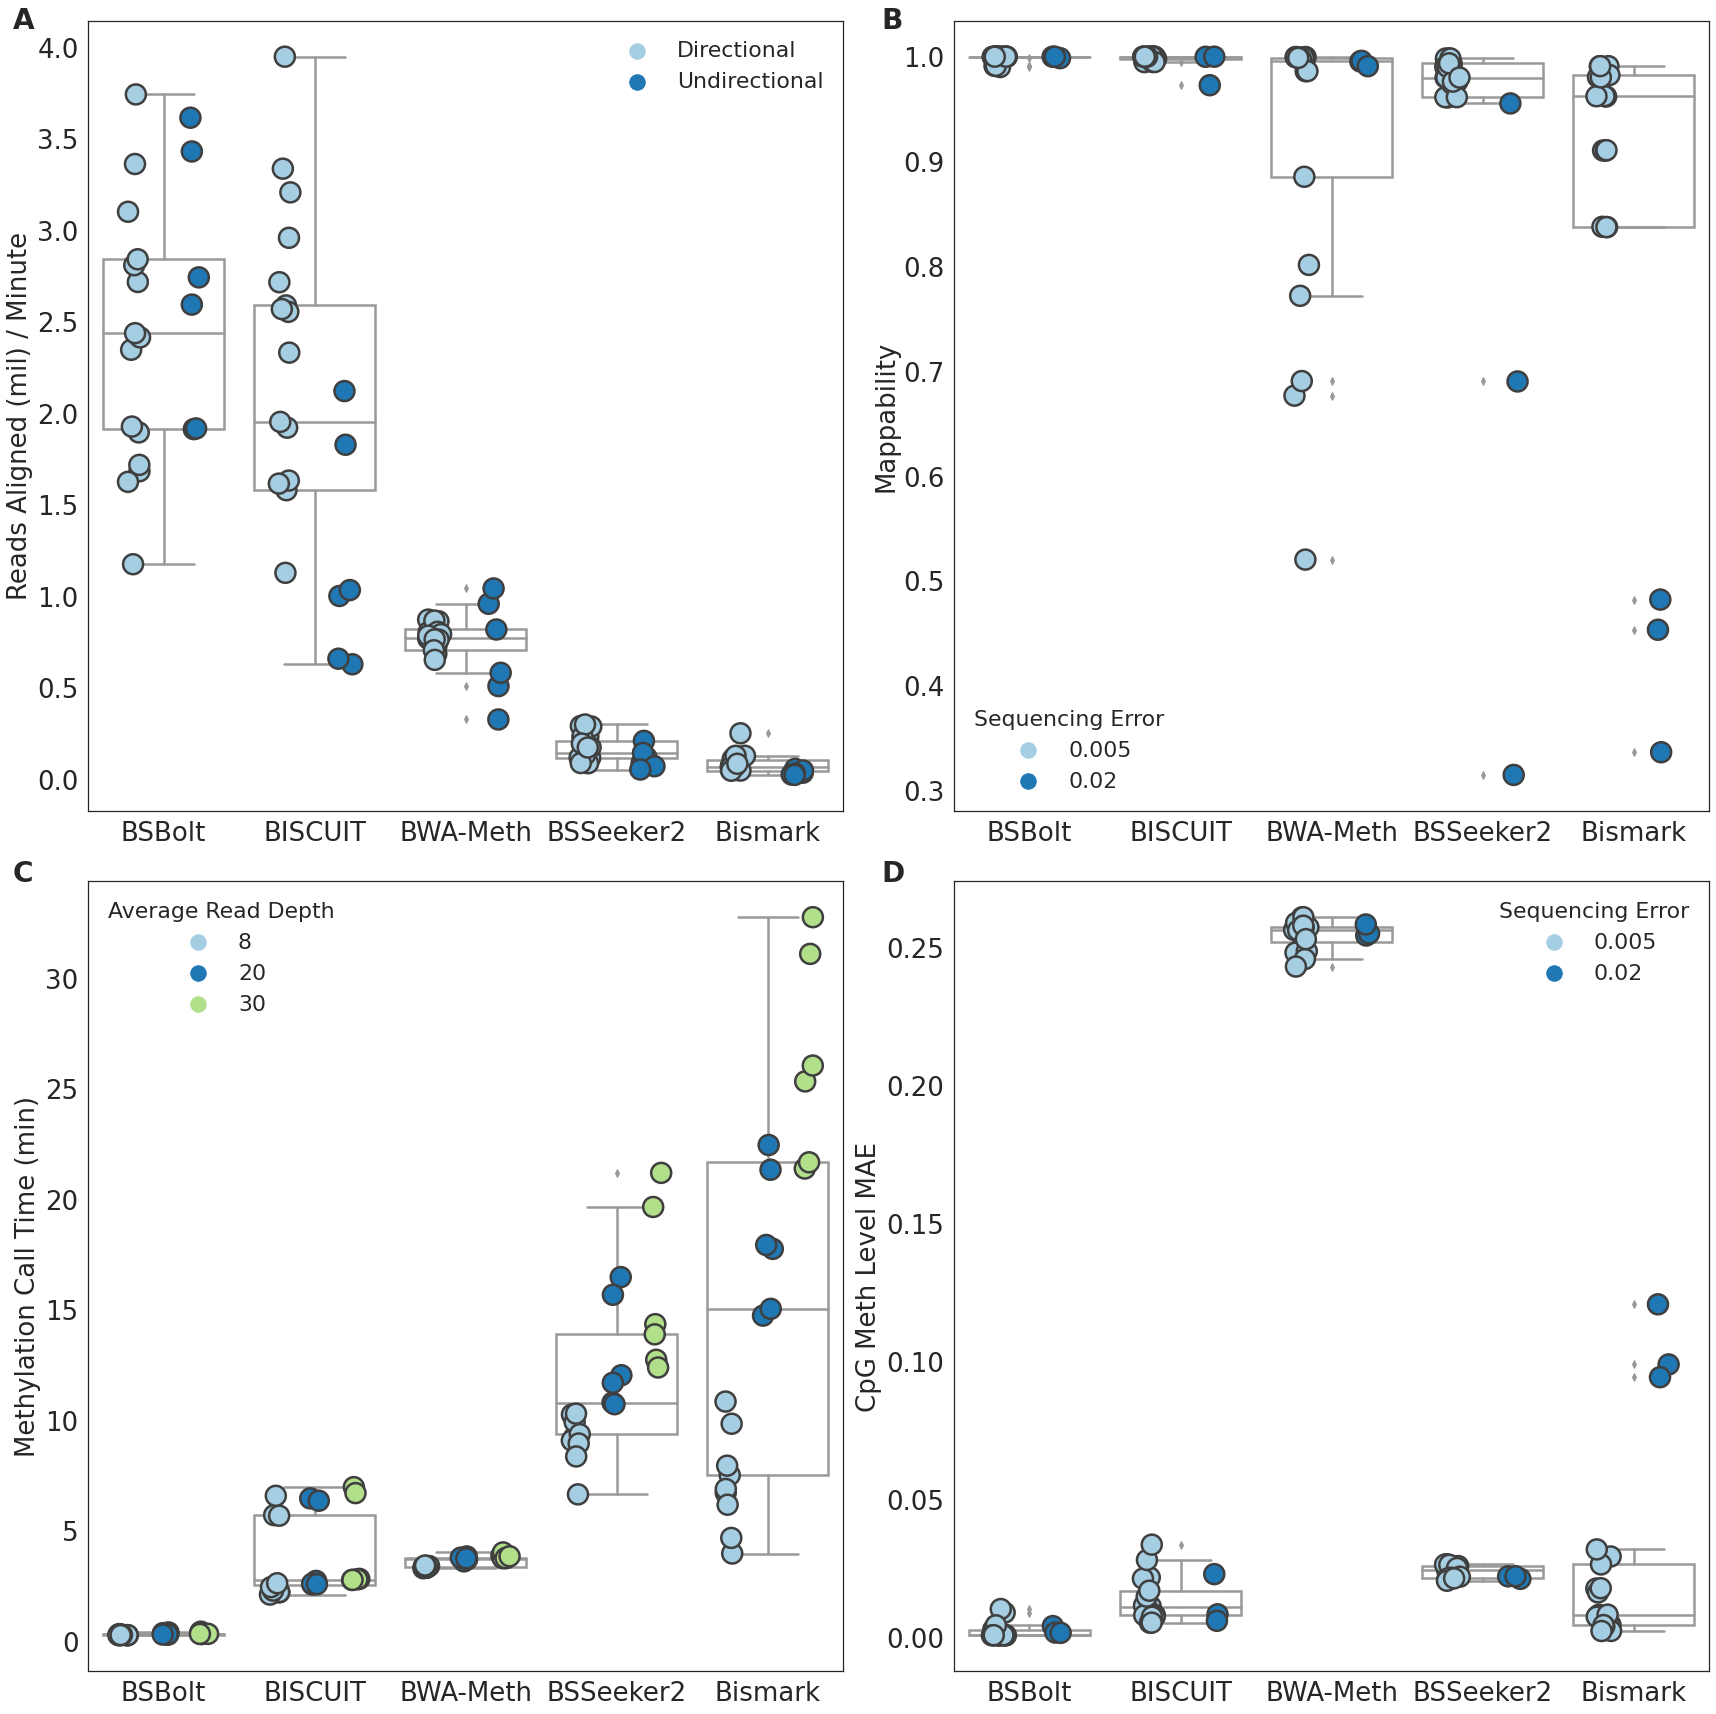

In [61]:
# plot the model results 
fig, ax = plt.subplots(2, 2, figsize=(24,24))

tool_order = ['BSBolt', 'BISCUIT', 'BWA-Meth','BSSeeker2', 'Bismark']

sns.boxplot(x='Tool', y='Reads Aligned (mil) / Minute', dodge='Read Length', 
            data=output_df, ax=ax[0,0], order=tool_order, linewidth=2.5, color='white')
sns.stripplot(x='Tool', y='Reads Aligned (mil) / Minute', hue='Library Type',
              data=output_df, ax=ax[0,0], order=tool_order, jitter=True, dodge=True, linewidth=2.5, s=20)

#sns.scatterplot(x='Off Target Proportion', y='On Target Proportion', data=plot_df, ax=ax[0,1], hue='Tool', style='Tool')
sns.boxplot(x='Tool', y='Mappability', data=output_df, ax=ax[0,1], order=tool_order, 
            linewidth=2.5, color='white')
sns.stripplot(x='Tool', y='Mappability', hue='Sequencing Error', data=output_df, ax=ax[0,1], order=tool_order, 
              jitter=True, dodge=True, linewidth=2.5, s=20)


sns.boxplot(x='Tool', y='Methylation Call Time (min)', data=output_df, ax=ax[1,0], order=tool_order, 
            linewidth=2.5, color='white')
sns.stripplot(x='Tool', y='Methylation Call Time (min)', hue='Average Read Depth', data=output_df, ax=ax[1,0], 
              order=tool_order,
             jitter=True, dodge=True, linewidth=2.5, s=20)

sns.boxplot(x='Tool', y='CpG Meth Level MAE', data=output_df, ax=ax[1,1], order=tool_order, linewidth=2.5, color='white')
sns.stripplot(x='Tool', y='CpG Meth Level MAE', hue='Sequencing Error', data=output_df, ax=ax[1,1], order=tool_order,
             jitter=True, dodge=True, linewidth=2.5, s=20)



ax[0, 0].text(-0.1,.99, f'A', transform=ax[0,0].transAxes, fontsize=28, weight='bold')
ax[0, 1].text(1.05,.99, f'B', transform=ax[0,0].transAxes, fontsize=28, weight='bold')
ax[1, 0].text(-0.1,1, f'C', transform=ax[1,0].transAxes, fontsize=28, weight='bold')
ax[1, 1].text(1.05,1, f'D', transform=ax[1,0].transAxes, fontsize=28, weight='bold')

ax[0,0].set_xlabel('')
ax[0,0].legend(loc=0)
ax[0,1].set_xlabel('')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')


plt.tight_layout()
plt.savefig('Figure2.png', dpi=100)
plt.show()

### Calculate Stats

In [62]:
tool_comp_cats = [
 'Mapped Reads',
 'Mappability',
 'On Target Alignments / Total',
 'Off Target Alignments / Total',
 'Alignment Time (min)',
 'Relative Alignment Time',
 'Reads Aligned (mil) / Minute',
 'CpG Meth Level MAE',
 'CpG Meth Level STD',
 'CpG Coverage MAE',
 'CpG Coverage STD',
 'Methylation Call Time (min)',
 'Relative Methylation Call Time']

In [63]:
tool_stats = {}

for tool in set(output_df['Tool'].values):
    tool_df = output_df.loc[output_df['Tool'] == tool]
    for library_type in ['Undirectional', 'Directional']:
        tool_stat = tool_df.loc[tool_df['Library Type'] == library_type][tool_comp_cats].mean(axis=0).to_dict()
        tool_stat['Simulation Grouping'] = 'Library Type'
        tool_stat['Comparison Libraries'] = len(tool_df.loc[tool_df['Library Type'] == library_type][tool_comp_cats].index)
        tool_stats[f'{tool} ({library_type})'] = tool_stat
    for sequencing_type in ['Paired End', 'Single End']:
        tool_stat = tool_df.loc[tool_df['Sequencing Type'] == sequencing_type][tool_comp_cats].mean(axis=0).to_dict()
        tool_stat['Simulation Grouping'] = 'Sequencing Type'
        tool_stat['Comparison Libraries'] = len(tool_df.loc[tool_df['Sequencing Type'] == sequencing_type][tool_comp_cats].index)
        tool_stats[f'{tool} ({sequencing_type})'] = tool_stat
    for read_len in [50, 100, 150]:
        tool_stat = tool_df.loc[tool_df['Read Length'] == read_len][tool_comp_cats].mean(axis=0).to_dict()
        tool_stat['Simulation Grouping'] = 'Read Length'
        tool_stat['Comparison Libraries'] = len(tool_df.loc[tool_df['Read Length'] == read_len][tool_comp_cats].index)
        tool_stats[f'{tool} ({read_len} bp Libraries)'] = tool_stat
    for error in [0.005, 0.02]:
        tool_stat = tool_df.loc[tool_df['Sequencing Error'] == error][tool_comp_cats].mean(axis=0).to_dict()
        tool_stat['Simulation Grouping'] = 'Sequencing Error'
        tool_stat['Comparison Libraries'] = len(tool_df.loc[tool_df['Sequencing Error'] == error][tool_comp_cats].index)
        tool_stats[f'{tool} (Sim. Err. {error})'] = tool_stat
    tool_stat = tool_df[tool_comp_cats].mean(axis=0).to_dict()
    tool_stat['Comparison Libraries'] = len(tool_df[tool_comp_cats].index)
    tool_stat['Simulation Grouping'] = 'All'
    tool_stats[f'{tool}  (All)'] = tool_stat

In [64]:
tool_stats_df = pd.DataFrame(tool_stats).T

In [65]:
tool_stats_df.to_csv('sim_tool_stats.csv', float_format='%.3f')

In [66]:
tool_stats_df.loc[tool_stats_df['Simulation Grouping'] == 'Library Type']

,Mapped Reads,Mappability,On Target Alignments / Total,Off Target Alignments / Total,Alignment Time (min),Relative Alignment Time,Reads Aligned (mil) / Minute,CpG Meth Level MAE,CpG Meth Level STD,CpG Coverage MAE,CpG Coverage STD,Methylation Call Time (min),Relative Methylation Call Time,Simulation Grouping,Comparison Libraries
BSBolt (Undirectional),1.60927e+07,0.998332,0.997156,0.00284403,5.68223,1,2.70237,0.00280673,0.0183886,0.20284,0.573384,0.361736,1,Library Type,6
BSBolt (Directional),6.8699e+06,0.998739,0.997709,0.00229092,2.66468,1,2.38661,0.00220431,0.02024,0.0661131,0.2569,0.307016,1,Library Type,15
Bismark (Undirectional),1.48637e+07,0.944093,0.749753,0.250247,425.827,76.2058,0.0363877,0.0102446,0.0293492,0.82242,1.45148,26.3801,72.673,Library Type,6
Bismark (Directional),5.88824e+06,0.839977,0.999954,4.59482e-05,81.1116,30.1217,0.0928155,0.030047,0.0686596,0.727545,0.919469,11.589,36.6843,Library Type,15
BWA-Meth (Undirectional),1.09816e+07,0.724364,0.706363,0.293637,22.8506,4.12935,0.705854,0.258211,0.204381,6.17708,3.91162,3.83995,10.7341,Library Type,6
BWA-Meth (Directional),6.85415e+06,0.996295,0.998848,0.00115205,8.54479,3.03738,0.774922,0.253137,0.224798,6.10211,2.48882,3.51343,11.5306,Library Type,15
BISCUIT (Undirectional),1.6107e+07,0.998878,0.997948,0.00205199,13.3726,2.46479,1.21177,0.0156876,0.0298479,1.24559,1.28444,4.14471,11.0689,Library Type,6
BISCUIT (Directional),6.86033e+06,0.997218,0.997292,0.0027079,2.66313,1.00075,2.40289,0.0123136,0.0325757,0.486931,0.69337,3.68193,11.8493,Library Type,15
BSSeeker2 (Undirectional),1.58953e+07,0.983044,0.749872,0.250128,145.877,26.5878,0.113853,0.0258468,0.110811,14.7345,3.84147,15.6992,42.9523,Library Type,6
BSSeeker2 (Directional),6.59688e+06,0.91734,0.999785,0.000215155,38.6845,14.4743,0.181816,0.0230659,0.106006,6.27346,2.44101,10.6357,34.3357,Library Type,15


In [67]:
tool_stats_df.loc[tool_stats_df['Simulation Grouping'] == 'All']

,Mapped Reads,Mappability,On Target Alignments / Total,Off Target Alignments / Total,Alignment Time (min),Relative Alignment Time,Reads Aligned (mil) / Minute,CpG Meth Level MAE,CpG Meth Level STD,CpG Coverage MAE,CpG Coverage STD,Methylation Call Time (min),Relative Methylation Call Time,Simulation Grouping,Comparison Libraries
BSBolt (All),9.50498e+06,0.998623,0.997551,0.00244895,3.52684,1,2.47683,0.00237643,0.019711,0.105178,0.347324,0.32265,1,All,21
Bismark (All),8.45265e+06,0.869724,0.928468,0.0715321,179.602,43.2886,0.0766933,0.0243892,0.057428,0.754652,1.07147,15.815,46.9668,All,21
BWA-Meth (All),8.03341e+06,0.918601,0.915281,0.0847192,12.6322,3.34937,0.755188,0.254587,0.218964,6.12353,2.89533,3.60672,11.303,All,21
BISCUIT (All),9.50224e+06,0.997692,0.99748,0.0025205,5.72297,1.41905,2.06257,0.0132776,0.0317963,0.70369,0.862248,3.81415,11.6263,All,21
BSSeeker2 (All),9.25358e+06,0.936112,0.928381,0.0716189,69.3109,17.9353,0.162398,0.0238605,0.107379,8.69089,2.84114,12.0824,36.7976,All,21


In [68]:
tool_stats_df.loc[tool_stats_df['Simulation Grouping'] == 'Sequencing Error']

,Mapped Reads,Mappability,On Target Alignments / Total,Off Target Alignments / Total,Alignment Time (min),Relative Alignment Time,Reads Aligned (mil) / Minute,CpG Meth Level MAE,CpG Meth Level STD,CpG Coverage MAE,CpG Coverage STD,Methylation Call Time (min),Relative Methylation Call Time,Simulation Grouping,Comparison Libraries
BSBolt (Sim. Err. 0.005),1.03725e+07,0.998471,0.997986,0.00201407,3.72283,1,2.59864,0.00234016,0.0188097,0.116772,0.374495,0.326536,1,Sequencing Error,18
BSBolt (Sim. Err. 0.02),4.29981e+06,0.999533,0.994942,0.00505823,2.35087,1,1.74594,0.00259409,0.0251187,0.0356153,0.184298,0.299337,1,Sequencing Error,3
Bismark (Sim. Err. 0.005),9.57827e+06,0.944019,0.916552,0.0834484,204.893,48.48,0.0637859,0.0109973,0.0381193,0.525174,0.991335,17.6269,52.0034,Sequencing Error,18
Bismark (Sim. Err. 0.02),1.69892e+06,0.423958,0.999966,3.42983e-05,27.8568,12.1401,0.154137,0.10474,0.173281,2.13152,1.55229,4.94349,16.7474,Sequencing Error,3
BWA-Meth (Sim. Err. 0.005),8.65885e+06,0.906008,0.901442,0.0985584,13.748,3.50214,0.763227,0.254341,0.215401,6.51283,3.04732,3.64468,11.296,Sequencing Error,18
BWA-Meth (Sim. Err. 0.02),4.28075e+06,0.994157,0.998316,0.00168412,5.93691,2.43278,0.706951,0.256058,0.240345,3.78774,1.98342,3.37894,11.3449,Sequencing Error,3
BISCUIT (Sim. Err. 0.005),1.03794e+07,0.998825,0.998117,0.00188263,6.28787,1.48909,2.11117,0.0134027,0.031098,0.759394,0.909732,3.80197,11.3476,Sequencing Error,18
BISCUIT (Sim. Err. 0.02),4.23915e+06,0.9909,0.993652,0.00634771,2.33358,0.99879,1.77098,0.0125269,0.0359863,0.369468,0.577345,3.88724,13.2991,Sequencing Error,3
BSSeeker2 (Sim. Err. 0.005),1.0246e+07,0.983216,0.916469,0.0835307,77.7934,19.6295,0.152455,0.0241831,0.107808,9.49426,2.98621,12.69,38.2625,Sequencing Error,18
BSSeeker2 (Sim. Err. 0.02),3.29887e+06,0.653491,0.999852,0.000147671,18.4154,7.77016,0.222056,0.021925,0.104808,3.87071,1.97074,8.43694,28.008,Sequencing Error,3


In [69]:
table2 = tool_stats_df.loc[tool_stats_df['Simulation Grouping'].isin(['All', 'Library Type'])]

In [70]:
bis_df = output_df.loc[output_df['Library Type'] == 'Directional'].loc[output_df['Sequencing Error'] == 0.005].loc[output_df['Tool'] == 'Bismark']

In [71]:
bis_df['Relative Alignment Time']

pe_directional_50_x_1_bismark                  27.5274
pe_directional_100_x_1_bismark                 38.1445
pe_directional_150_x_1_bismark                 37.8704
se_directional_50_x_1_bismark                  35.5216
se_directional_100_x_1_bismark                 42.7354
se_directional_150_x_1_bismark                 41.1186
pe_low_coverage_directional_50_x_1_bismark      22.254
pe_low_coverage_directional_100_x_1_bismark    33.1085
pe_low_coverage_directional_150_x_1_bismark    34.7834
se_low_coverage_directional_50_x_1_bismark     28.2431
se_low_coverage_directional_100_x_1_bismark    36.9477
se_low_coverage_directional_150_x_1_bismark    37.1507
Name: Relative Alignment Time, dtype: object

In [72]:
for cat in float_format_cats:
    output_df[cat] = output_df[cat].map('{:,.3f}'.format)

In [73]:
output_df.to_csv('Sim_Comps.tsv', index=False, sep='\t')